In [1]:
import os
import time
import typing
from pathlib import Path
from textwrap import dedent

import numpy as np
from pydrake.all import (
    Concatenate,
    Context,
    DiagramBuilder,
    InverseKinematics,
    MultibodyPlant,
    PiecewisePolynomial,
    PointCloud,
    Rgba,
    RigidTransform,
    RotationMatrix,
    Simulator,
    Solve,
    StartMeshcat,
    TrajectorySource,
    ConstantVectorSource
)

from manipulation import running_as_notebook
# from manipulation.letter_generation import create_sdf_asset_from_letter
from manipulation.meshcat_utils import AddMeshcatTriad
from manipulation.station import LoadScenario, MakeHardwareStation, AddPointClouds
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph

from utils import *

In [2]:
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [210]:
drivers = f"""
model_drivers:
    iiwa: !IiwaDriver
        control_mode: position_only
        hand_model_name: wsg
    wsg: !SchunkWsgDriver {{}}

cameras:
    camera0:
        name: camera0
        depth: true
        X_PB:
            base_frame: camera0::base

    camera1:
        name: camera1
        depth: true
        X_PB:
            base_frame: camera1::base

    camera2:
        name: camera2
        depth: true
        X_PB:
            base_frame: camera2::base
"""

directives = f"""
directives:
    - add_model:
        name: iiwa
        file: package://drake_models/iiwa_description/urdf/iiwa14_primitive_collision.urdf
        default_joint_positions:
            iiwa_joint_1: [-1.57]
            iiwa_joint_2: [0.1]
            iiwa_joint_3: [0]
            iiwa_joint_4: [-1.2]
            iiwa_joint_5: [0]
            iiwa_joint_6: [ 1.6]
            iiwa_joint_7: [0]
    - add_weld:
        parent: world
        child: iiwa::iiwa_link_0
        X_PC:
            translation: [0, -0.5, 0]
            rotation: !Rpy {{ deg: [0, 0, 180] }}
    - add_model:
        name: wsg
        file: package://manipulation/hydro/schunk_wsg_50_with_tip.sdf
    - add_weld:
        parent: iiwa::iiwa_link_7
        child: wsg::body
        X_PC:
            translation: [0, 0, 0.09]
            rotation: !Rpy {{deg: [90, 0, 90]}}
    - add_model:
        name: floor
        file: package://stackbot/floor.sdf
    - add_weld:
        parent: world
        child: floor::floor_link
        X_PC:
            translation: [0, 0, -0.05]
    - add_model:
        name: platform
        file: package://stackbot/platform.sdf
    - add_weld:
        parent: world
        child: platform::platform_link
"""

block_numbers = np.random.choice(range(11), size=np.random.randint(4, 7), replace=False)
print("This scenario uses blocks:", block_numbers)
blocks = [f"block{i}" for i in block_numbers]

block_sdfs = [f"""
    - add_model:
        name: {block}
        file: package://stackbot/{block}.sdf
""" for block in blocks]

scenario_yaml = "\n".join([directives] + block_sdfs)

This scenario uses blocks: [ 1 10  8  6  7]


In [211]:
# Add cameras to the scenario
scenario_yaml += f"""
    - add_frame:
        name: camera0_origin
        X_PF:
            base_frame: world
            rotation: !Rpy {{ deg: [-120.0, 0.0, 180.0]}}
            translation: [0, 1.0, 0.8]

    - add_model:
        name: camera0
        file: package://manipulation/camera_box.sdf

    - add_weld:
        parent: camera0_origin
        child: camera0::base

    - add_frame:
        name: camera1_origin
        X_PF:
            base_frame: world
            rotation: !Rpy {{ deg: [-125, 0.0, 90.0]}}
            translation: [1.0, 0.1, 0.8]

    - add_model:
        name: camera1
        file: package://manipulation/camera_box.sdf

    - add_weld:
        parent: camera1_origin
        child: camera1::base

    - add_frame:
        name: camera2_origin
        X_PF:
            base_frame: world
            rotation: !Rpy {{ deg: [-120.0, 0.0, -90.0]}}
            translation: [-1.0, 0.1, 0.8]

    - add_model:
        name: camera2
        file: package://manipulation/camera_box.sdf

    - add_weld:
        parent: camera2_origin
        child: camera2::base
"""

In [212]:
scenario_with_drivers_yaml = scenario_yaml + drivers

In [213]:
scenario = LoadScenario(data=scenario_with_drivers_yaml)
station = MakeHardwareStation(
    scenario=scenario,
    meshcat=meshcat,
    package_xmls=["../assets/models/package.xml"],
)
plant = station.GetSubsystemByName("plant")

builder = DiagramBuilder()
builder.AddSystem(station)

# Connect initial positions to builder
force_limit = builder.AddSystem(ConstantVectorSource([60.0]))
builder.Connect(force_limit.get_output_port(), station.GetInputPort("wsg.force_limit"))

initial_iiwa_pos = builder.AddSystem(ConstantVectorSource(np.zeros(station.GetInputPort("iiwa.position").size())))
builder.Connect(initial_iiwa_pos.get_output_port(), station.GetInputPort("iiwa.position"))

initial_gripper_pos = builder.AddSystem(ConstantVectorSource([0.0]))
builder.Connect(initial_gripper_pos.get_output_port(), station.GetInputPort("wsg.position"))

# Add the point clouds to the diagram and export to builder
pointClouds = AddPointClouds(
    scenario=scenario, station=station, builder=builder, meshcat=meshcat
)
builder.ExportOutput(pointClouds["camera0"].get_output_port(), "camera0_point_cloud")
builder.ExportOutput(pointClouds["camera1"].get_output_port(), "camera1_point_cloud")
builder.ExportOutput(pointClouds["camera2"].get_output_port(), "camera2_point_cloud")

diagram = builder.Build()


In [214]:
diagram_context = diagram.CreateDefaultContext()
plant_context = diagram.GetMutableSubsystemContext(plant, diagram_context)

randomize_blocks(blocks, plant, plant_context)

In [215]:
simulator = Simulator(diagram, diagram_context)

# run simulation!
meshcat.StartRecording()
if running_as_notebook:
    simulator.set_target_realtime_rate(1.0)
simulator.AdvanceTo(5)
meshcat.StopRecording()
meshcat.PublishRecording()

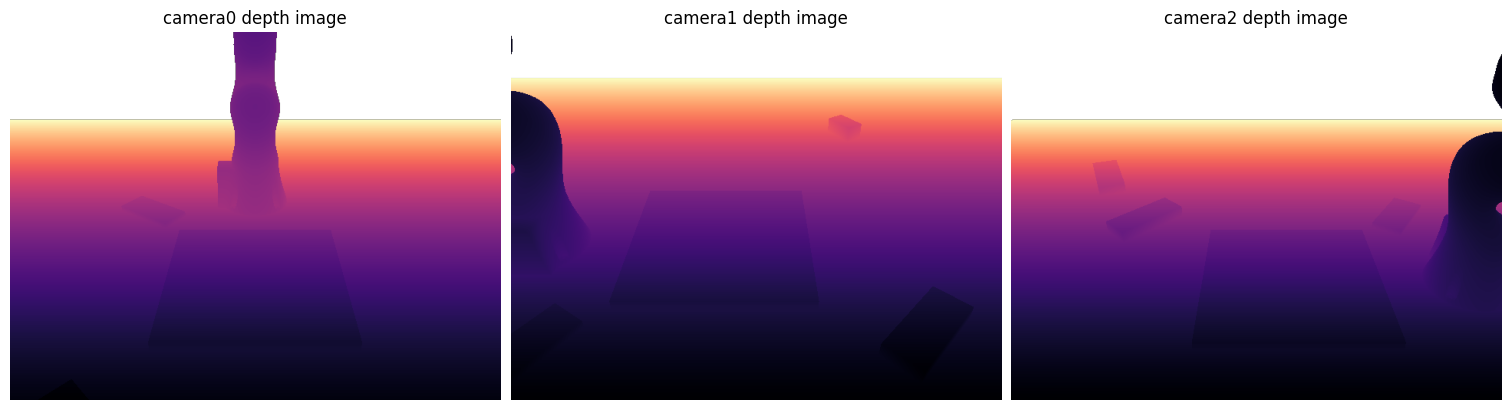

In [216]:
# Visualize camera depth outputs
import matplotlib.pyplot as plt
cameras = ["camera0", "camera1", "camera2"]
station_context = diagram.GetSubsystemContext(station, diagram_context)

fig, axes = plt.subplots(
    1, len(cameras), figsize=(5 * len(cameras), 4), constrained_layout=True
)
for ax, cam in zip(axes, cameras):
    img = station.GetOutputPort(f"{cam}.depth_image").Eval(station_context)
    depth_img = np.array(img.data, copy=False).reshape(img.height(), img.width(), -1)
    depth_img = np.ma.masked_invalid(depth_img)
    img = ax.imshow(depth_img, cmap="magma")
    ax.set_title(f"{cam} depth image")
    ax.axis("off")

plt.show()

In [217]:
# Evaluate all camera outputs
camera0_point_cloud = diagram.GetOutputPort("camera0_point_cloud").Eval(diagram_context)
camera1_point_cloud = diagram.GetOutputPort("camera1_point_cloud").Eval(diagram_context)
camera2_point_cloud = diagram.GetOutputPort("camera2_point_cloud").Eval(diagram_context)

# concatenate the point clouds
point_cloud = Concatenate([camera0_point_cloud, camera1_point_cloud, camera2_point_cloud])

# downsample the point clouds
point_cloud = point_cloud.VoxelizedDownSample(0.01)


In [218]:
"""
Given a point cloud with rgbs and xyzs, returns a new point cloud of
all the points within the offset of the given rgb color.
"""
def isolate_blocks_by_color(point_cloud: PointCloud, color: np.array, eps: np.array = [100, 150, 150]):

    xyzs = point_cloud.xyzs()
    rgbs = point_cloud.rgbs()

    lower_bound = (color - eps).reshape(3, 1)
    upper_bound = (color + eps).reshape(3, 1)

    mask = np.all((rgbs >= lower_bound) & (rgbs <= upper_bound), axis=0)
    filtered_xyzs = xyzs[:, mask]

    new_pc = PointCloud(new_size=filtered_xyzs.shape[1])
    new_pc.mutable_xyzs()[:] = filtered_xyzs
    print(filtered_xyzs.shape)

    return new_pc

In [219]:
block_color = np.array([0, 255, 0])

cropped_pc = isolate_blocks_by_color(point_cloud, block_color)

# Visualize the point cloud
meshcat.SetObject(
    "cropped_point_cloud", cropped_pc, point_size=0.05, rgba=Rgba(1, 0, 0)
)

(3, 1310)


In [220]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [221]:
def dbscan(eps: float, min_samples: int, points: np.array):
    points = points[:].T
    assert (np.shape(points)[1] == 3)
    scaler = MinMaxScaler()
    scaled_pts = scaler.fit_transform(points)
    clustering = DBSCAN(eps=eps, min_samples=min_samples).fit(scaled_pts)
    return clustering

In [222]:
clusters = dbscan(0.06, 4, cropped_pc.xyzs())

In [ ]:
# clusters.components_ --> shape (n_core_samples, n_features)
print(clusters.components_.shape)
# Plan: create a unique point cloud for each of the n_features
# display each in a different color
def display_clusters(dbscan_obj, points):
    _, n_features = dbscan_obj.components_.shape
    labels = dbscan_obj.labels_
    for n in range(n_features+1):
        mask = np.array(list(map(lambda x: x == n, labels)))
        points_in_cluster_n = points.T[mask]
        print(points_in_cluster_n[0])
        pc = PointCloud(new_size=points_in_cluster_n.shape[0])
        pc.mutable_xyzs()[:] = points_in_cluster_n.T
        color = Rgba(np.random.rand(), np.random.rand(), np.random.rand())
        meshcat.SetObject(
        f"cluster_{n}", pc, point_size=0.05, rgba=color
        )

(1301, 3)


In [224]:
display_clusters(clusters, cropped_pc.xyzs())

0
(476, 3)
1
(311, 3)
2
(300, 3)
3
(214, 3)
